### Khởi tạo và trực quan hóa mạng nghệ sĩ từ ma trận đồng xuất hiện

Đồ thị gốc có 675 nút và 55262 cạnh


C:\Users\acer\AppData\Local\Temp\ipykernel_23496\63854370.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


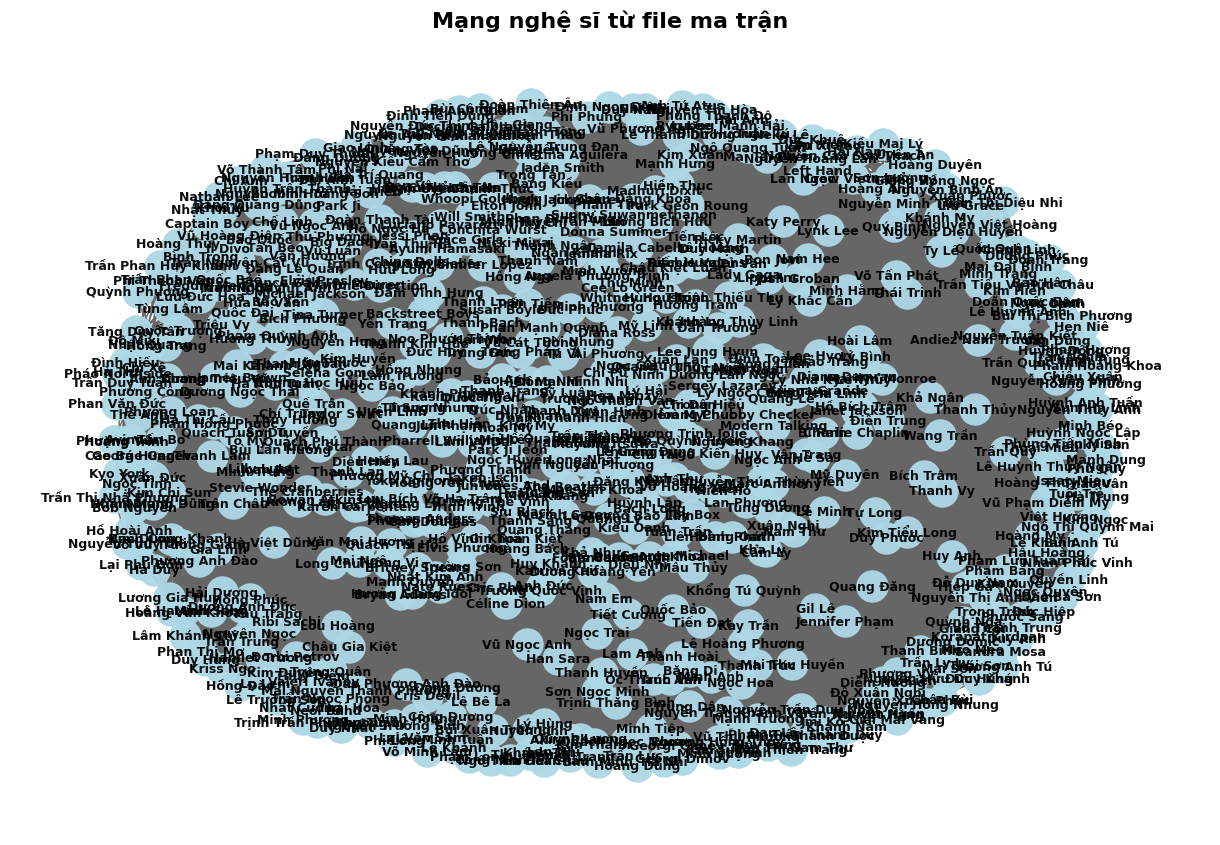


Thống kê cơ bản:
Số nút: 675
Số cạnh (cặp nghệ sĩ khác nhau): 55262
Tổng số lần hợp tác (trọng số cạnh): 58843
Mật độ: 0.243
Độ (degree) trung bình: 163.74
Độ lớn nhất: 470
Hệ số clustering trung bình: 0.890


In [ ]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# ---------- 1) Đọc file ma trận & tạo đồ thị ----------
def create_graph_from_matrix(csv_path: str, min_weight: int = 1) -> nx.Graph:
    """
    Đọc ma trận đồng-xuất hiện (hàng/cột là nghệ sĩ, ô là số lần cùng xuất hiện),
    dựng Graph vô hướng có trọng số 'weight'.
    min_weight: chỉ giữ cạnh có trọng số >= ngưỡng (lọc nhiễu).
    """
    df = pd.read_csv(csv_path, index_col=0, encoding="utf-8-sig")

    edges = []
    idx = list(df.index)
    cols = list(df.columns)

    # đảm bảo hàng/cột khớp nhau 
    if idx != cols:
        # nếu không trùng thứ tự, ta sẽ map theo tên
        col_pos = {c: i for i, c in enumerate(cols)}
        for i, a1 in enumerate(idx):
            for a2 in idx[i+1:]:
                j = col_pos.get(a2)
                if j is None: 
                    continue
                w = df.iloc[i, j]
                if pd.notna(w) and w >= min_weight:
                    edges.append((a1, a2, float(w)))
    else:
        # ma trận vuông chuẩn, đọc tam giác trên cho nhanh
        n = len(idx)
        for i in range(n):
            for j in range(i+1, n):
                w = df.iat[i, j]
                if pd.notna(w) and w >= min_weight:
                    edges.append((idx[i], idx[j], float(w)))

    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

# ---------- 2) Vẽ đồ thị ----------
def draw_graph(G: nx.Graph, title: str = "Mạng nghệ sĩ (từ file ma trận)"):
    # layout cố định cho đẹp
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    # tô màu đồng nhất 
    node_color = "lightblue"
    # độ dày cạnh theo trọng số (nhìn trực quan hơn)
    edge_widths = [0.5 + 0.6 * G[u][v].get("weight", 1.0) for u, v in G.edges()]

    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos,
        node_color=node_color, edge_color="#666",
        node_size=500, width=edge_widths,
        with_labels=True, font_size=9, font_weight="bold", alpha=0.95
    )
    plt.title(title, fontsize=16, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ---------- 3) In thống kê cơ bản ----------
def print_basic_stats(G: nx.Graph):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density   = nx.density(G)
    degrees   = [d for _, d in G.degree()]
    avg_deg   = float(np.mean(degrees)) if degrees else 0.0
    max_deg   = max(degrees) if degrees else 0
    avg_clust = nx.average_clustering(G) if num_nodes > 1 else 0.0
    # tổng trọng số cạnh (tổng số lần hợp tác thực tế)
    total_weight = sum(d.get("weight", 1.0) for _, _, d in G.edges(data=True))

    print("\nThống kê cơ bản:")
    print(f"Số nút: {num_nodes}")
    print(f"Số cạnh (cặp nghệ sĩ khác nhau): {num_edges}")
    print(f"Tổng số lần hợp tác (trọng số cạnh): {int(total_weight)}")
    print(f"Mật độ: {density:.3f}")
    print(f"Độ (degree) trung bình: {avg_deg:.2f}")
    print(f"Độ lớn nhất: {max_deg}")
    print(f"Hệ số clustering trung bình: {avg_clust:.3f}")

# ==============================================
CSV_PATH = r"D:/MangXaHoi/gameshow_vietnam/artist_coappearance_matrix1.csv"  
G_original = create_graph_from_matrix(CSV_PATH, min_weight=1)

print(f"Đồ thị gốc có {G_original.number_of_nodes()} nút và {G_original.number_of_edges()} cạnh")
draw_graph(G_original, title="Mạng nghệ sĩ từ file ma trận")
print_basic_stats(G_original)

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)


### Tách dữ liệu mạng thành tập Train/Test và sinh mẫu âm (Negative Samples) để phục vụ bài toán dự đoán liên kết

Tập train: 44209 cạnh
Tập test: 11053 cạnh
Đồ thị train có 44209 cạnh
Negative samples cho test: 11053 cặp
Đồ thị train vẫn liên thông


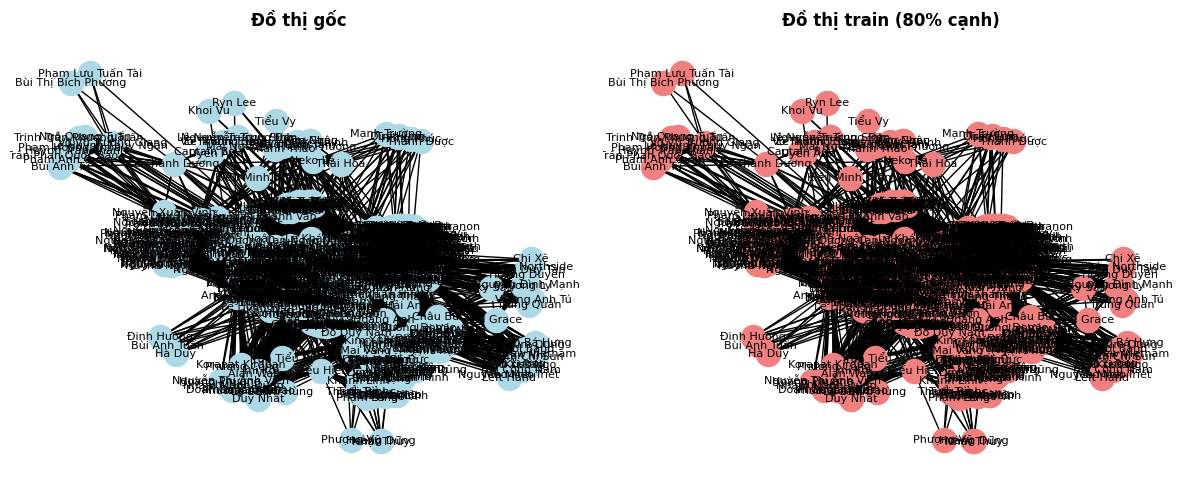

In [3]:
# ====================== TÁCH DỮ LIỆU TRAIN/TEST ======================

def split_edges(G, test_ratio=0.2, seed=42):
    """
    Tách cạnh của đồ thị thành tập train và test
    """
    random.seed(seed)
    np.random.seed(seed)

    edges = list(G.edges())
    random.shuffle(edges)

    split_point = int(len(edges) * (1 - test_ratio))
    train_edges = edges[:split_point]
    test_edges = edges[split_point:]

    # Tạo đồ thị train (chỉ chứa train edges)
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    return G_train, train_edges, test_edges


def generate_negative_samples(G, num_samples, seed=42):
    """
    Tạo các cặp nút không có cạnh (negative samples)
    """
    random.seed(seed)
    negative_edges = []
    nodes = list(G.nodes())

    while len(negative_edges) < num_samples:
        u = random.choice(nodes)
        v = random.choice(nodes)

        if u != v and not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.append((u, v))

    return negative_edges


# --- Thực hiện tách dữ liệu ---
G_train, train_edges, test_edges = split_edges(G_original, test_ratio=0.2)

print(f"Tập train: {len(train_edges)} cạnh")
print(f"Tập test: {len(test_edges)} cạnh")
print(f"Đồ thị train có {G_train.number_of_edges()} cạnh")

# Tạo negative samples cho test
test_negative = generate_negative_samples(G_train, len(test_edges))
print(f"Negative samples cho test: {len(test_negative)} cặp")

# Kiểm tra tính kết nối của đồ thị train
if nx.is_connected(G_train):
    print("Đồ thị train vẫn liên thông")
else:
    print("Đồ thị train không liên thông - có thể ảnh hưởng đến một số thuật toán")
    components = list(nx.connected_components(G_train))
    print(f"Số thành phần liên thông: {len(components)}")

# --- Vẽ trực quan ---
pos = nx.spring_layout(G_original, seed=42)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
nx.draw(G_original, pos, node_color='lightblue', node_size=300,
        with_labels=True, font_size=8)
plt.title('Đồ thị gốc', fontweight='bold')

plt.subplot(1, 2, 2)
nx.draw(G_train, pos, node_color='lightcoral', node_size=300,
        with_labels=True, font_size=8)
plt.title('Đồ thị train (80% cạnh)', fontweight='bold')

plt.tight_layout()
plt.show()


### Tính điểm tương đồng (Similarity Scores) giữa các cặp nghệ sĩ bằng các chỉ số mạng như Common Neighbors, Jaccard, Adamic-Adar, Preferential Attachment và Resource Allocation


In [4]:
import networkx as nx
import numpy as np

def get_similarity_scores(G, method, edges):
    """
    Hàm tính điểm tương đồng (similarity score) cho các cặp đỉnh.
    G: đồ thị huấn luyện
    method: tên phương pháp ('common_neighbors', 'jaccard', 'adamic_adar', 'preferential_attachment', 'resource_allocation')
    edges: danh sách cặp đỉnh cần tính điểm
    """
    scores = []
    if method == "common_neighbors":
        for u, v in edges:
            cn = len(list(nx.common_neighbors(G, u, v)))
            scores.append(cn)

    elif method == "jaccard":
        preds = nx.jaccard_coefficient(G, edges)
        for _, _, p in preds:
            scores.append(p)

    elif method == "adamic_adar":
        preds = nx.adamic_adar_index(G, edges)
        for _, _, p in preds:
            scores.append(p)

    elif method == "preferential_attachment":
        preds = nx.preferential_attachment(G, edges)
        for _, _, p in preds:
            scores.append(p)

    elif method == "resource_allocation":
        preds = nx.resource_allocation_index(G, edges)
        for _, _, p in preds:
            scores.append(p)

    else:
        raise ValueError(f"Phương pháp {method} không được hỗ trợ!")

    return scores


### Đánh giá hiệu quả các thuật toán dự đoán liên kết bằng AUC-ROC, AUC-PR và Average Precision, kèm biểu đồ so sánh (ROC, Precision–Recall, Bar Chart)


Kết quả đánh giá các phương pháp:
                      Method  AUC-ROC  AUC-PR  Average Precision
0           Common Neighbors   0.9574  0.9308             0.9306
1        Jaccard Coefficient   0.9637  0.9387             0.9387
2          Adamic-Adar Index   0.9623  0.9342             0.9342
3    Preferential Attachment   0.8428  0.8377             0.8377
4  Resource Allocation Index   0.9687  0.9400             0.9400


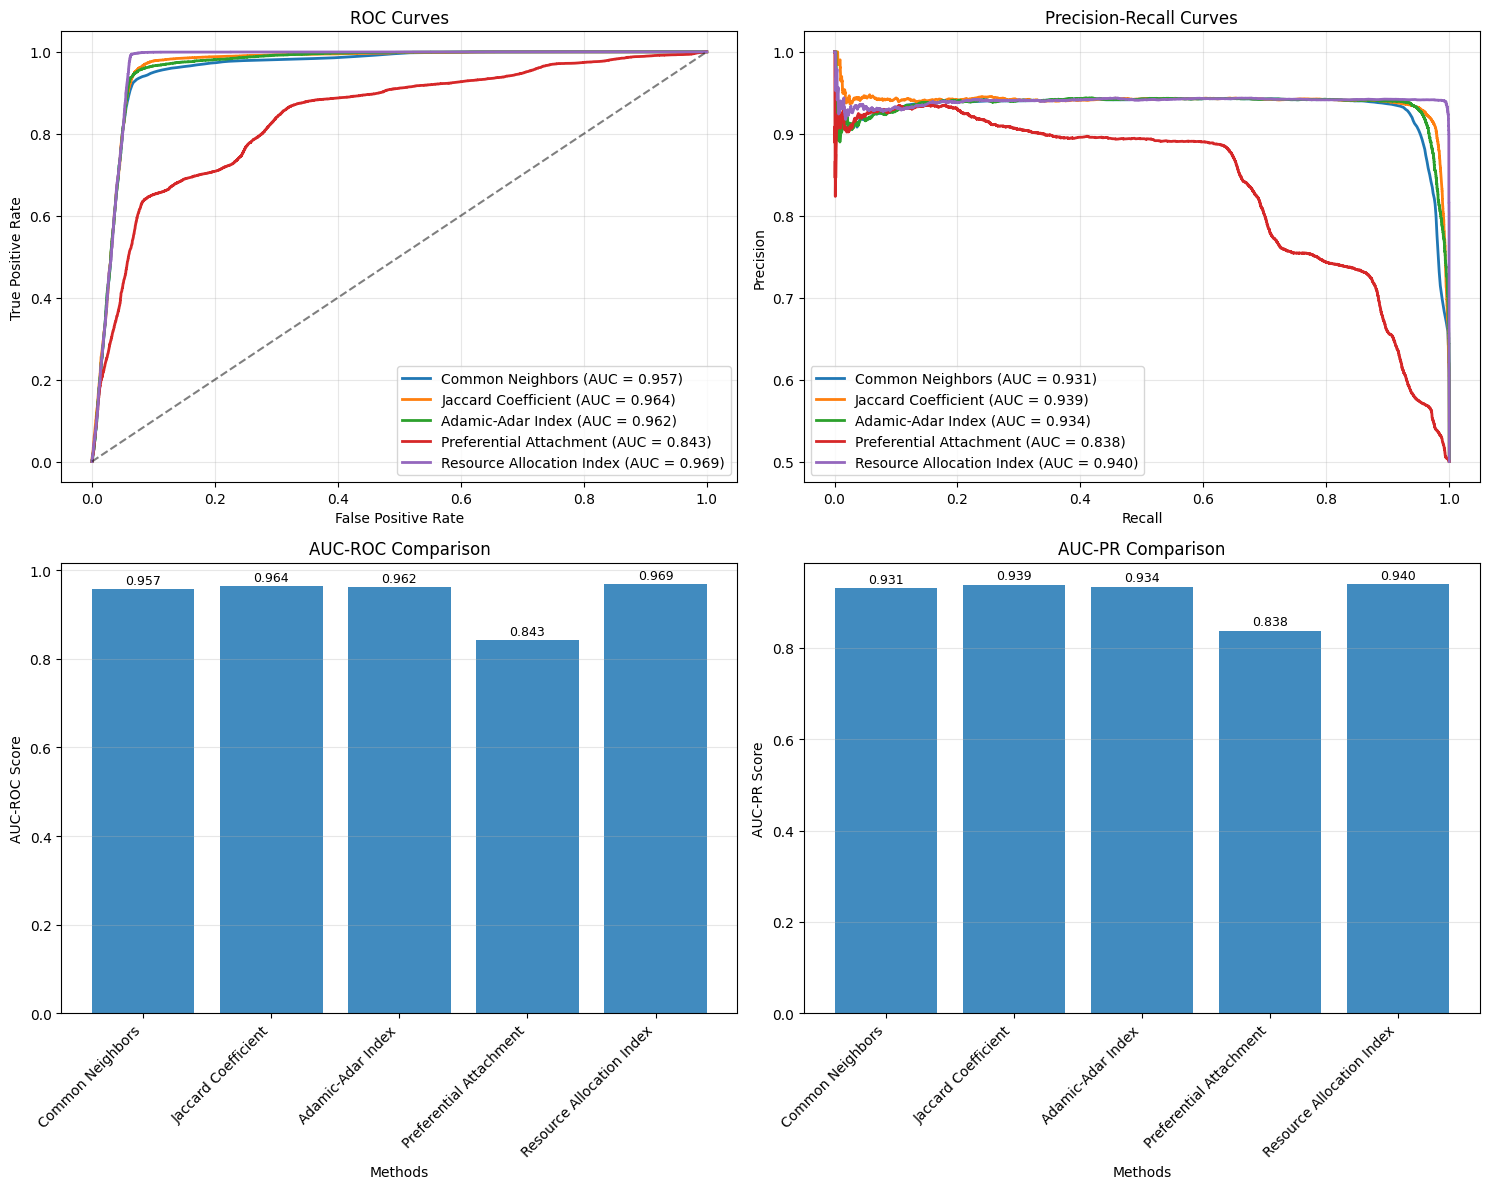


Xếp hạng theo AUC-ROC:
- Resource Allocation Index: 0.9687
- Jaccard Coefficient: 0.9637
- Adamic-Adar Index: 0.9623
- Common Neighbors: 0.9574
- Preferential Attachment: 0.8428

Xếp hạng theo AUC-PR:
- Resource Allocation Index: 0.9400
- Jaccard Coefficient: 0.9387
- Adamic-Adar Index: 0.9342
- Common Neighbors: 0.9308
- Preferential Attachment: 0.8377


In [ ]:
# ====================== ĐÁNH GIÁ  ======================
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Tạo test_data: ghép điểm dự đoán (scores) và nhãn (labels)
methods = ['common_neighbors', 'jaccard', 'adamic_adar', 'preferential_attachment', 'resource_allocation']
method_names = ['Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar Index',
                'Preferential Attachment', 'Resource Allocation Index']

# Tính điểm cho pos/neg rồi ghép lại
pos_labels = np.ones(len(test_edges), dtype=int)
neg_labels = np.zeros(len(test_negative), dtype=int)
labels_all = np.concatenate([pos_labels, neg_labels])

# Tạo test_data dưới dạng DataFrame
records = {}

# Nhãn và cặp edge
labels_all = np.concatenate([np.ones(len(test_edges), dtype=int),
                             np.zeros(len(test_negative), dtype=int)])
edges_all = test_edges + test_negative
records['edge'] = edges_all
records['label'] = labels_all

# Tính điểm cho từng phương pháp
for m in methods:
    pos_scores = np.array(get_similarity_scores(G_train, m, test_edges), dtype=float)
    neg_scores = np.array(get_similarity_scores(G_train, m, test_negative), dtype=float)
    records[m] = np.concatenate([pos_scores, neg_scores])

# Chuyển sang DataFrame
test_data = pd.DataFrame(records)


# 2) Hàm evaluate 
def evaluate_method(scores, labels, method_name):
    """
    Đánh giá một phương pháp dự đoán liên kết
    """
    # Loại bỏ NaN/Inf để tránh lỗi
    mask = ~(np.isnan(scores) | np.isinf(scores))
    scores = scores[mask]
    labels = labels[mask]

    # AUC-ROC
    fpr, tpr, _ = roc_curve(labels, scores)
    auc_roc = auc(fpr, tpr)

    # AUC-PR
    precision, recall, _ = precision_recall_curve(labels, scores)
    auc_pr = auc(recall, precision)

    # Average Precision
    avg_precision = average_precision_score(labels, scores)

    return {
        'method': method_name,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'avg_precision': avg_precision,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall
    }

# 3) Chạy đánh giá cho tất cả phương pháp
results = []
evaluation_data = {}

for method, name in zip(methods, method_names):
    scores = test_data[method]
    labels = test_data['label']

    # Đánh giá & lưu lại
    eval_result = evaluate_method(scores, labels, name)
    results.append(eval_result)
    evaluation_data[name] = eval_result

# 4) Bảng kết quả
results_df = pd.DataFrame([
    {
        'Method': r['method'],
        'AUC-ROC': r['auc_roc'],
        'AUC-PR': r['auc_pr'],
        'Average Precision': r['avg_precision']
    }
    for r in results
]).round(4)

print("Kết quả đánh giá các phương pháp:")
print("="*60)
print(results_df)

# 5) Vẽ ROC/PR + bar chart AUC
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves
ax1 = axes[0, 0]
for name, data in evaluation_data.items():
    ax1.plot(data['fpr'], data['tpr'],
             label=f"{name} (AUC = {data['auc_roc']:.3f})", linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
ax2 = axes[0, 1]
for name, data in evaluation_data.items():
    ax2.plot(data['recall'], data['precision'],
             label=f"{name} (AUC = {data['auc_pr']:.3f})", linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bar chart AUC-ROC
ax3 = axes[1, 0]
methods_list = results_df['Method'].tolist()
auc_roc_values = results_df['AUC-ROC'].tolist()
bars = ax3.bar(range(len(methods_list)), auc_roc_values, alpha=0.85)
ax3.set_xlabel('Methods')
ax3.set_ylabel('AUC-ROC Score')
ax3.set_title('AUC-ROC Comparison')
ax3.set_xticks(range(len(methods_list)))
ax3.set_xticklabels(methods_list, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, auc_roc_values):
    ax3.text(bar.get_x() + bar.get_width()/2., value + 0.005,
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Bar chart AUC-PR
ax4 = axes[1, 1]
auc_pr_values = results_df['AUC-PR'].tolist()
bars = ax4.bar(range(len(methods_list)), auc_pr_values, alpha=0.85)
ax4.set_xlabel('Methods')
ax4.set_ylabel('AUC-PR Score')
ax4.set_title('AUC-PR Comparison')
ax4.set_xticks(range(len(methods_list)))
ax4.set_xticklabels(methods_list, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, auc_pr_values):
    ax4.text(bar.get_x() + bar.get_width()/2., value + 0.005,
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 6) Xếp hạng
print("\nXếp hạng theo AUC-ROC:")
for i, row in results_df.sort_values('AUC-ROC', ascending=False).iterrows():
    print(f"- {row['Method']}: {row['AUC-ROC']:.4f}")

print("\nXếp hạng theo AUC-PR:")
for i, row in results_df.sort_values('AUC-PR', ascending=False).iterrows():
    print(f"- {row['Method']}: {row['AUC-PR']:.4f}")
# =======================================================================



### PHÂN TÍCH CHI TIẾT CÁC ĐIỂM SỐ

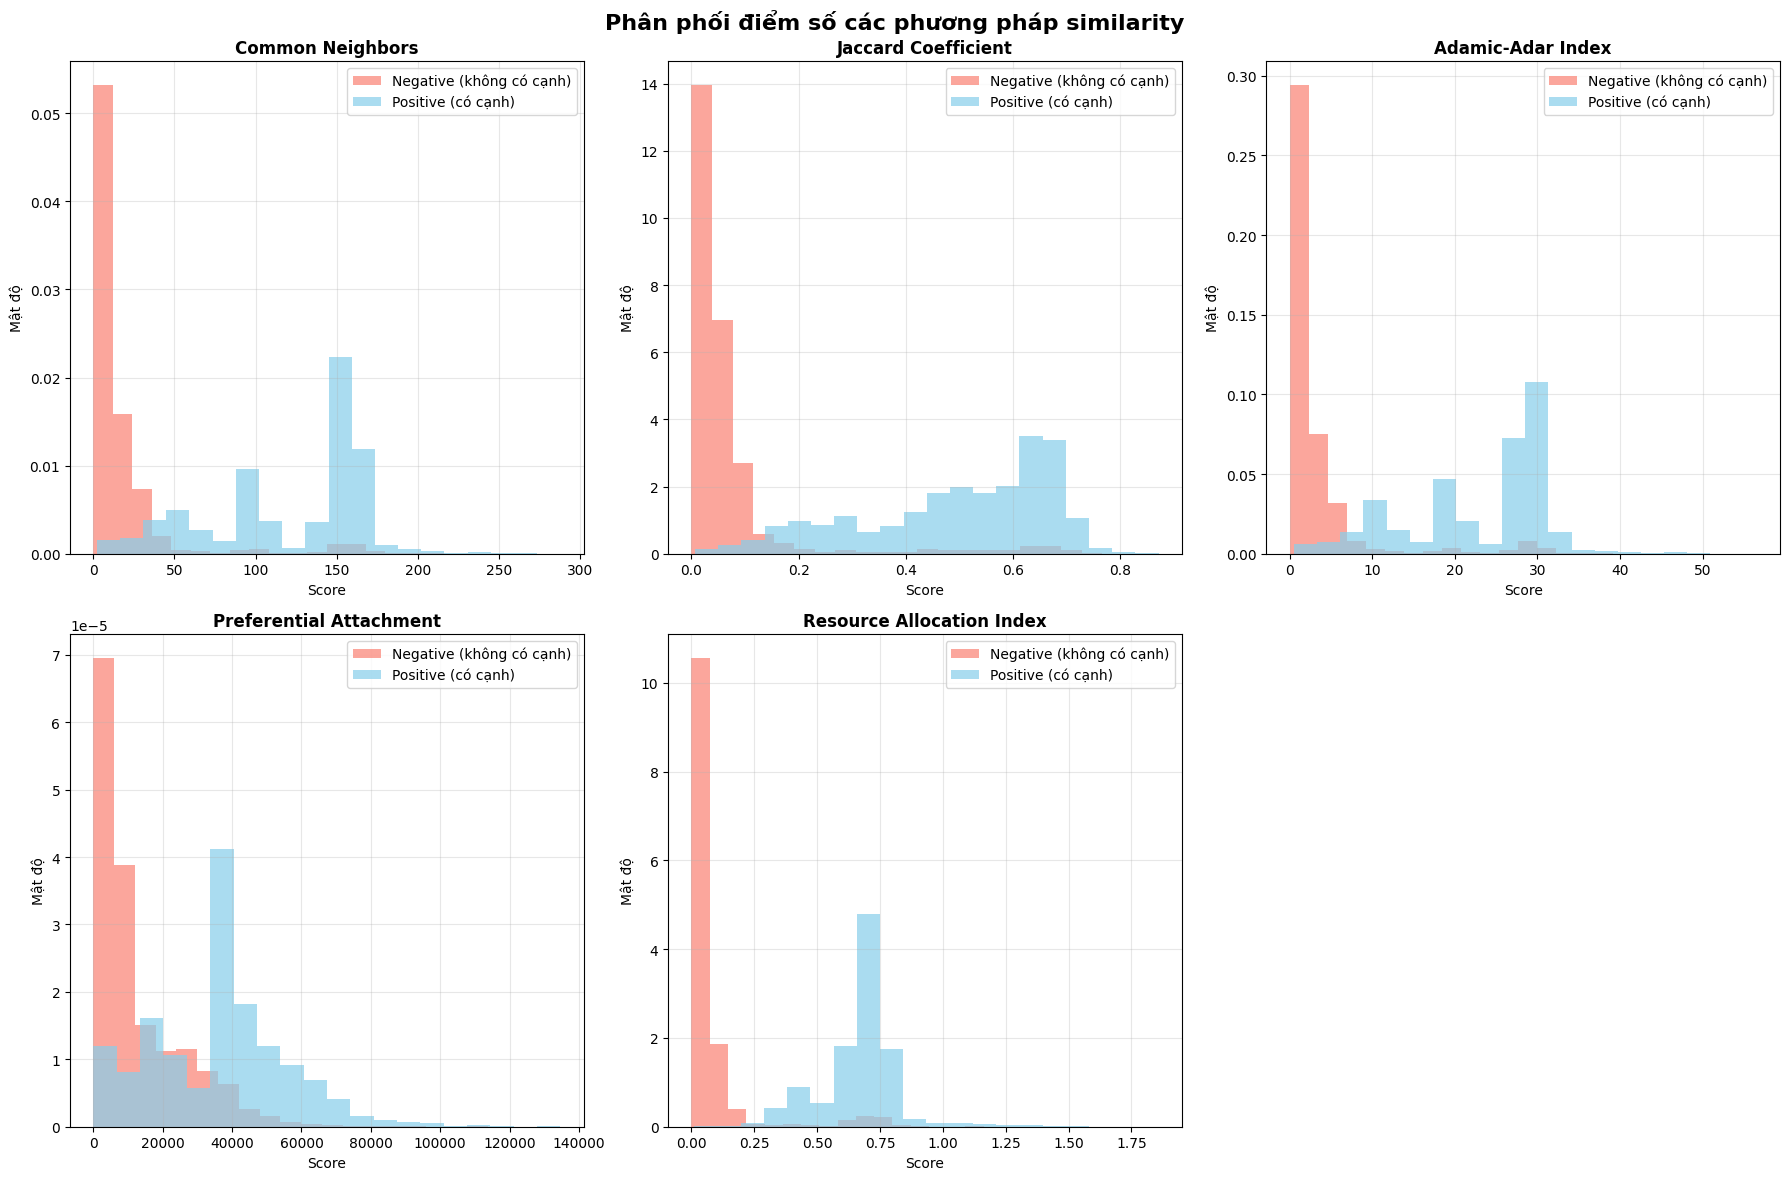

=== PHÂN TÍCH CÁC TRƯỜNG HỢP ĐẶC BIỆT ===

1. Top 5 cặp Negative có điểm Adamic-Adar cao nhất:
   Cặp (Hòa Minzy, Thúy Ngân): AA=46.025, CN=240.0
   Hàng xóm Hòa Minzy: ['Phượng Hằng', 'Trần Thu Hà', 'Đen Vâu', 'Triệu Vy', 'Thanh Vy', 'Nguyễn Huỳnh Sơn', 'Đoàn Thiên Ân', 'Lady Gaga', 'Minh Sang', 'Quế Trân', 'Thanh Ngân', 'Điền Trung', 'Hoài Lâm', 'Khánh Ly', 'Tấn Beo', 'Elvis Phương', 'Hứa Vĩ Văn', 'Vũ Ngọc Ánh', 'Minh Nhí', 'Thanh Nam', 'Hoàng Trinh', 'Cris Devil', 'Lê Hoàng Phương', 'France Gall', 'Nguyễn Anh Tú', 'Ngọc Ánh', 'Hồng Nhung', 'Selena Gomez', 'Thảo Trang', 'Hoàng Sơn', 'Việt Trinh', 'Katrina Kaif', 'Park Ji Jeon', 'Takeo Ischi', 'Thu Trang', 'Minh Phương', 'Lynk Lee', 'Chí Tài', 'Bùi Lan Hương', 'Lan Phương', 'Hương Tràm', 'Park Ji', 'Nguyễn Việt Hoàng', 'Dương Hoàng Yến', 'Wang Trần', 'Kay Trần', 'Cao Thiên Trang', 'Thu Phương', 'Tuấn Hưng', 'Kim Tử Long', 'Thanh Kim Huệ', 'Trần Tiến', 'Camila Cabello', 'Thanh Lam', 'Hương Thủy', 'Thu Minh', 'Duy Phước', 'Vũ Phạm Diễm 

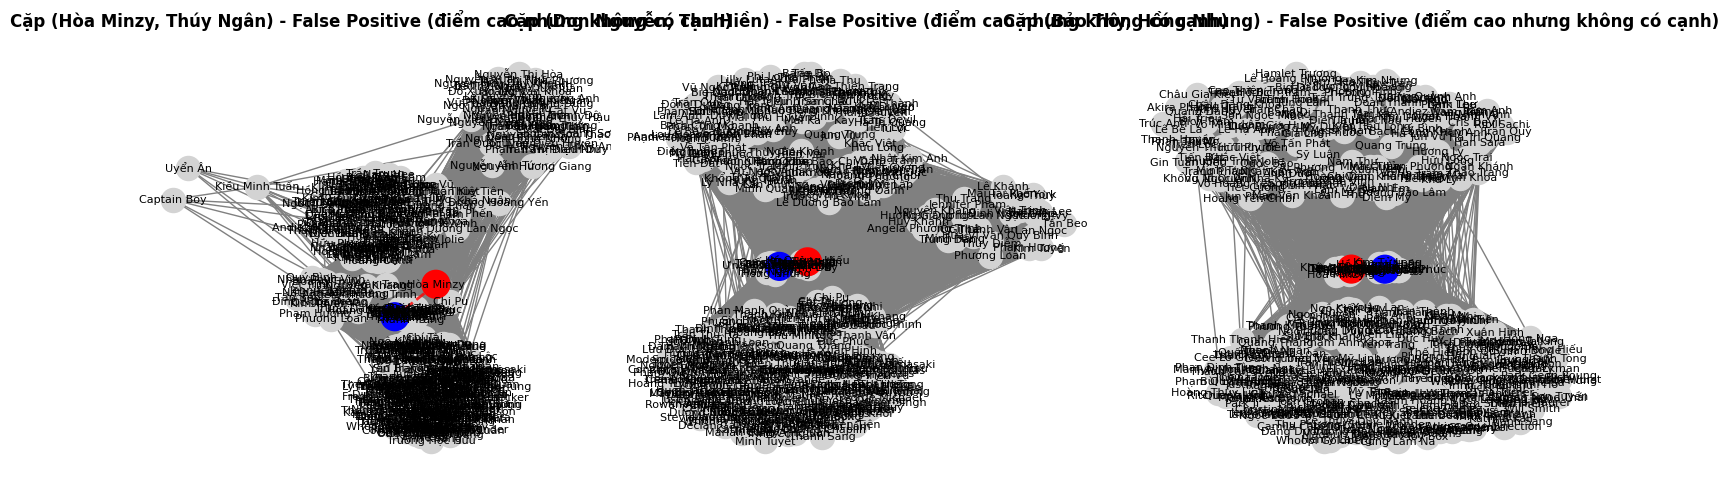

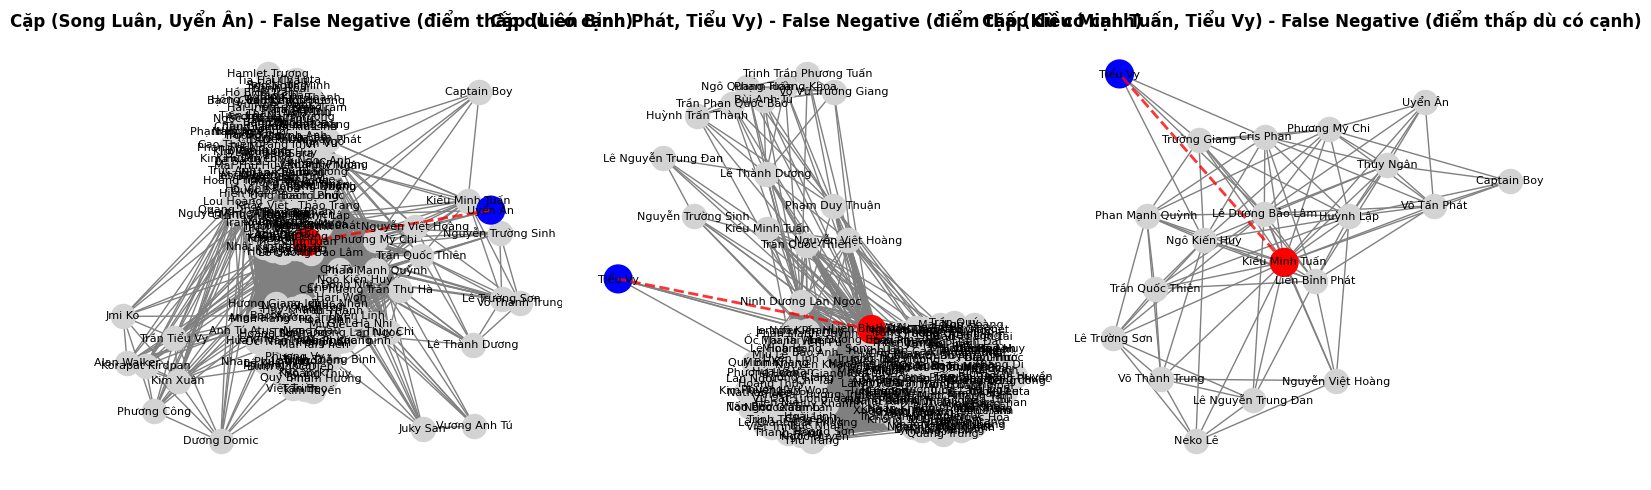

In [ ]:
# ================== PHÂN TÍCH CHI TIẾT CÁC ĐIỂM SỐ ==================

def analyze_score_distribution(test_data):
    """Vẽ phân phối điểm số của các phương pháp similarity"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Phân phối điểm số các phương pháp similarity', fontsize=16, fontweight='bold')

    methods = ['common_neighbors', 'jaccard', 'adamic_adar', 
               'preferential_attachment', 'resource_allocation']
    method_names = ['Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar Index',
                    'Preferential Attachment', 'Resource Allocation Index']

    for i, (method, name) in enumerate(zip(methods, method_names)):
        ax = axes[i//3, i%3]

        # Tách điểm số positive vs negative
        positive_scores = test_data[test_data['label'] == 1][method]
        negative_scores = test_data[test_data['label'] == 0][method]

        # Vẽ histogram
        ax.hist(negative_scores, bins=20, alpha=0.7, label='Negative (không có cạnh)',
                color='salmon', density=True)
        ax.hist(positive_scores, bins=20, alpha=0.7, label='Positive (có cạnh)',
                color='skyblue', density=True)

        ax.set_title(name, fontweight='bold')
        ax.set_xlabel('Score')
        ax.set_ylabel('Mật độ')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Xóa subplot thừa (2x3 = 6, nhưng chỉ có 5 phương pháp)
    axes[1, 2].remove()

    plt.tight_layout()
    plt.show()


def find_interesting_cases(test_data, G_train, topk=5):
    """Tìm các cặp đặc biệt để phân tích sâu"""
    print("=== PHÂN TÍCH CÁC TRƯỜNG HỢP ĐẶC BIỆT ===")

    # 1. False Positive mạnh (negative nhưng score Adamic-Adar cao)
    print(f"\n1. Top {topk} cặp Negative có điểm Adamic-Adar cao nhất:")
    top_negative = test_data[test_data['label'] == 0].nlargest(topk, 'adamic_adar')
    for _, row in top_negative.iterrows():
        u, v = row['edge']
        print(f"   Cặp ({u}, {v}): AA={row['adamic_adar']:.3f}, CN={row['common_neighbors']}")
        print(f"   Hàng xóm {u}: {list(G_train.neighbors(u))}")
        print(f"   Hàng xóm {v}: {list(G_train.neighbors(v))}")
        print()

    # 2. False Negative nặng (positive nhưng score Adamic-Adar thấp)
    print(f"\n2. Top {topk} cặp Positive có điểm Adamic-Adar thấp nhất:")
    low_positive = test_data[test_data['label'] == 1].nsmallest(topk, 'adamic_adar')
    for _, row in low_positive.iterrows():
        u, v = row['edge']
        print(f"   Cặp ({u}, {v}): AA={row['adamic_adar']:.3f}, CN={row['common_neighbors']}")
        print(f"   Hàng xóm {u}: {list(G_train.neighbors(u))}")
        print(f"   Hàng xóm {v}: {list(G_train.neighbors(v))}")
        print()

    return top_negative, low_positive


def visualize_special_cases(cases, G_train, title_suffix):
    """Vẽ subgraph của các cặp đặc biệt"""
    fig, axes = plt.subplots(1, min(3, len(cases)), figsize=(15, 5))

    if len(cases) == 1:
        axes = [axes]

    for i, (_, case) in enumerate(cases.head(3).iterrows()):
        ax = axes[i]
        u, v = case['edge']

        # Subgraph gồm u, v và hàng xóm
        neighbors = set([u, v]) | set(G_train.neighbors(u)) | set(G_train.neighbors(v))
        subG = G_train.subgraph(neighbors)
        pos = nx.spring_layout(subG, seed=42)

        nx.draw(subG, pos, ax=ax, node_color="lightgray", with_labels=True,
                node_size=300, font_size=8, edge_color="gray")
        nx.draw_networkx_nodes(subG, pos, nodelist=[u, v],
                               node_color=["red", "blue"], node_size=400, ax=ax)

        # Vẽ cạnh dự đoán 
        if not G_train.has_edge(u, v):
            ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
                    'r--', linewidth=2, alpha=0.8)

        ax.set_title(f"Cặp ({u}, {v}) - {title_suffix}", fontweight='bold')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# ================== GỌI CHẠY ==================
# Vẽ phân phối điểm số
analyze_score_distribution(test_data)

# Tìm & in các trường hợp đặc biệt
false_pos, false_neg = find_interesting_cases(test_data, G_train, topk=5)

# Vẽ subgraph minh họa
if len(false_pos) > 0:
    visualize_special_cases(false_pos, G_train, "False Positive (điểm cao nhưng không có cạnh)")
if len(false_neg) > 0:
    visualize_special_cases(false_neg, G_train, "False Negative (điểm thấp dù có cạnh)")


### Dự đoán top-k cặp nghệ sĩ tiềm năng có thể hợp tác trong tương lai dựa trên các chỉ số tương đồng (Adamic-Adar, Jaccard, v.v.)


In [ ]:
# === DỰ ĐOÁN CÁC CẶP KẾT NỐI TƯƠNG LAI ===
def predict_future_links(test_data, method="adamic_adar", topk=10):
    """
    Chọn ra top-k cặp có khả năng cao nhất sẽ hình thành liên kết trong tương lai
    dựa trên điểm similarity (Adamic-Adar, Jaccard, v.v.)
    """
    print(f"\n=== Dự đoán {topk} cặp có khả năng kết nối trong tương lai theo {method} ===")
    
    # Chỉ xét negative samples 
    candidates = test_data[test_data['label'] == 0].copy()
    
    # Sắp xếp theo điểm số giảm dần
    top_candidates = candidates.nlargest(topk, method)
    
    for i, row in top_candidates.iterrows():
        u, v = row['edge']
        score = row[method]
        print(f"{i+1}. Cặp ({u}, {v}) → {method} = {score:.3f}")
    
    return top_candidates

#  Dự đoán theo 3 chỉ số khác nhau
top_aa = predict_future_links(test_data, method="adamic_adar", topk=10)




=== Dự đoán 10 cặp có khả năng kết nối trong tương lai theo adamic_adar ===
17209. Cặp (Hòa Minzy, Thúy Ngân) → adamic_adar = 46.025
20589. Cặp (Don Nguyễn, Thu Hiền) → adamic_adar = 45.874
19630. Cặp (Bảo Thy, Hồng Nhung) → adamic_adar = 44.287
14648. Cặp (Cát Phượng, Trường Giang) → adamic_adar = 43.071
20445. Cặp (Cát Phượng, Trấn Thành) → adamic_adar = 41.912
21806. Cặp (Hồ Quang Hiếu, Chi Pu) → adamic_adar = 41.707
16310. Cặp (Khởi My, Trấn Thành) → adamic_adar = 41.229
13723. Cặp (Chí Tài, Vũ Cát Tường) → adamic_adar = 39.677
17433. Cặp (Duy Khánh, Chi Pu) → adamic_adar = 38.977
14948. Cặp (Trường Giang, Duy Khánh) → adamic_adar = 38.757


In [8]:
top_jc = predict_future_links(test_data, method="jaccard", topk=10)



=== Dự đoán 10 cặp có khả năng kết nối trong tương lai theo jaccard ===
11222. Cặp (Trần Nguyên Cát Vũ, Hoàng Thúy Hậu) → jaccard = 0.766
13627. Cặp (Lê Hạ Anh, Duy Phước) → jaccard = 0.747
20722. Cặp (Hồ Hoài Anh, Khánh My) → jaccard = 0.746
15702. Cặp (Xuân Phước, Thoại Miêu) → jaccard = 0.744
12903. Cặp (Karen Carpenter, Thúy Hường) → jaccard = 0.738
20523. Cặp (Hương Lan, Trọng Tấn) → jaccard = 0.735
12610. Cặp (Nguyễn Kiều Cẩm Thơ, Nguyễn Hoàng Lan) → jaccard = 0.734
13224. Cặp (Chiều Xuân, Kim Xuyến) → jaccard = 0.733
17083. Cặp (Bùi Lan Hương, Chubby Checker) → jaccard = 0.729
13796. Cặp (Bùi Lan Hương, Thúy Hường) → jaccard = 0.726


In [9]:
top_pa = predict_future_links(test_data, method="preferential_attachment", topk=10)


=== Dự đoán 10 cặp có khả năng kết nối trong tương lai theo preferential_attachment ===
21806. Cặp (Hồ Quang Hiếu, Chi Pu) → preferential_attachment = 119822.000
17209. Cặp (Hòa Minzy, Thúy Ngân) → preferential_attachment = 112728.000
17433. Cặp (Duy Khánh, Chi Pu) → preferential_attachment = 111216.000
22086. Cặp (Hồ Quang Hiếu, Bảo Anh) → preferential_attachment = 108962.000
14703. Cặp (Chí Tài, Khánh Phương) → preferential_attachment = 99600.000
20589. Cặp (Don Nguyễn, Thu Hiền) → preferential_attachment = 97744.000
20928. Cặp (Hồ Quang Hiếu, Minh Khang) → preferential_attachment = 94120.000
14948. Cặp (Trường Giang, Duy Khánh) → preferential_attachment = 93072.000
17885. Cặp (Long Nhật, Phương Mỹ Chi) → preferential_attachment = 90768.000
15980. Cặp (Khánh Phương, Ngọc Huyền) → preferential_attachment = 90300.000


### ===============================================================

### Tạo bộ dữ liệu huấn luyện và kiểm thử cho mô hình Machine Learning từ đặc trưng topo (Common Neighbors, Jaccard, Adamic-Adar, v.v.)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# === Tạo dữ liệu cho Machine Learning (X_train, X_test) ===

def compute_features(G, u, v):
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    cn = len(neighbors_u & neighbors_v)
    jaccard = cn / len(neighbors_u | neighbors_v) if len(neighbors_u | neighbors_v) > 0 else 0
    aa = sum(1 / np.log(len(list(G.neighbors(w))) + 1e-9) for w in neighbors_u & neighbors_v)
    pa = len(neighbors_u) * len(neighbors_v)
    ra = sum(1 / len(list(G.neighbors(w))) for w in neighbors_u & neighbors_v)
    sorensen = 2 * cn / (len(neighbors_u) + len(neighbors_v)) if (len(neighbors_u) + len(neighbors_v)) > 0 else 0
    hpi = cn / min(len(neighbors_u), len(neighbors_v)) if min(len(neighbors_u), len(neighbors_v)) > 0 else 0
    hdi = cn / max(len(neighbors_u), len(neighbors_v)) if max(len(neighbors_u), len(neighbors_v)) > 0 else 0
    salton = cn / np.sqrt(len(neighbors_u) * len(neighbors_v)) if len(neighbors_u) * len(neighbors_v) > 0 else 0
    return [cn, jaccard, aa, pa, ra, sorensen, hpi, hdi, salton]


def build_dataset(G, pos_edges, neg_edges):
    X, y = [], []
    for u, v in pos_edges:
        X.append(compute_features(G, u, v))
        y.append(1)
    for u, v in neg_edges:
        X.append(compute_features(G, u, v))
        y.append(0)
    return np.array(X), np.array(y)


# Negative edges cho train (tương tự test)
train_negative = generate_negative_samples(G_train, len(train_edges))

# Tạo dữ liệu train/test
X_train, y_train = build_dataset(G_train, train_edges, train_negative)
X_test, y_test = build_dataset(G_train, test_edges, test_negative)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Số lượng cạnh thật (1) trong train:", sum(y_train))
print("Số lượng cạnh giả (0) trong train:", len(y_train) - sum(y_train))


Train: (88418, 9) Test: (22106, 9)
Số lượng cạnh thật (1) trong train: 44209
Số lượng cạnh giả (0) trong train: 44209


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Huấn luyện 4 mô hình Machine Learning (Random Forest, Logistic Regression, xgboost, Neural Network)


Logistic Regression AUC = 0.9677


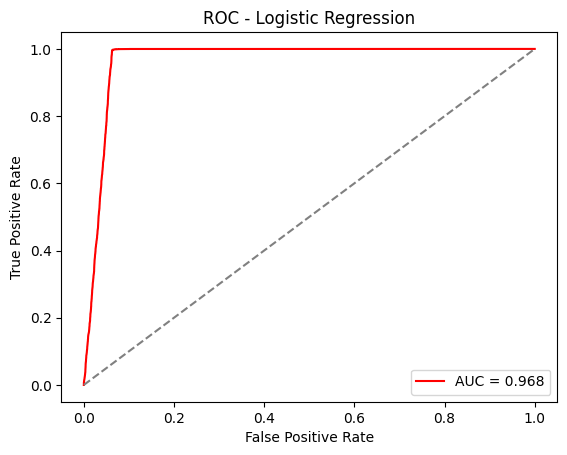

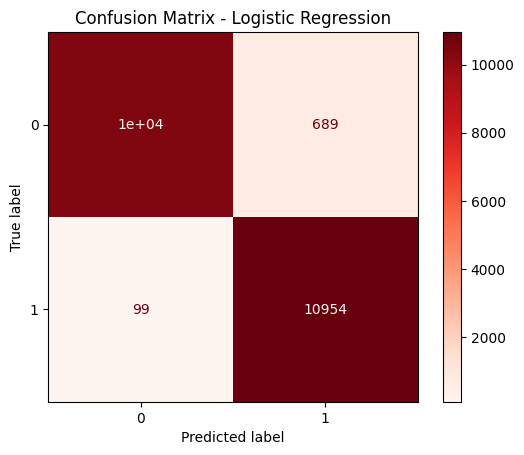

In [12]:
# ==================== HUẤN LUYỆN 4 MÔ HÌNH MACHINE LEARNING ====================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Danh sách đặc trưng
features = ["CN","Jaccard","AA","PA","RA","Sorensen","HPI","HDI","Salton"]

# -------------------------------------------------------------
# Logistic Regression
# -------------------------------------------------------------
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

auc_log = roc_auc_score(y_test, y_prob_log)
print(f"\nLogistic Regression AUC = {auc_log:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_log)
plt.plot(fpr, tpr, label=f"AUC = {auc_log:.3f}", color="red")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log)).plot(cmap="Reds")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()




Random Forest AUC = 0.9921


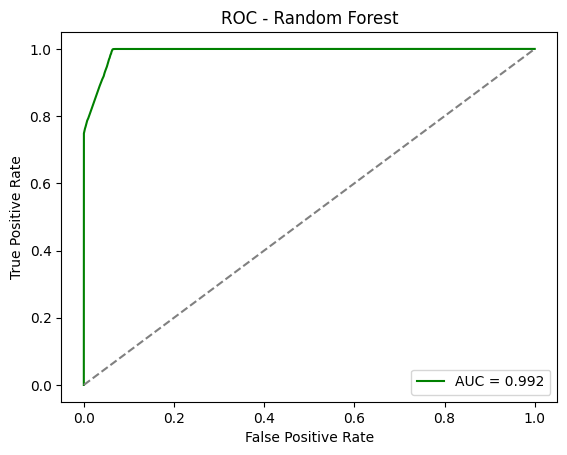

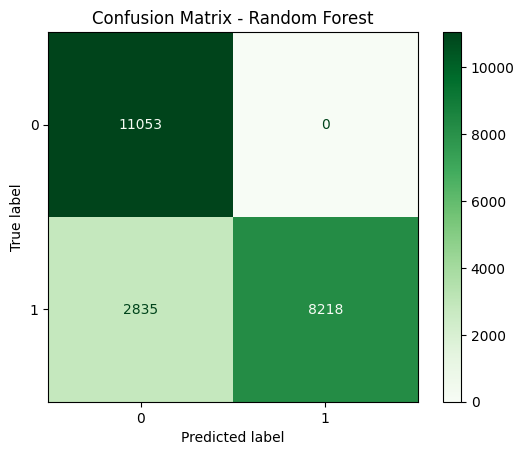

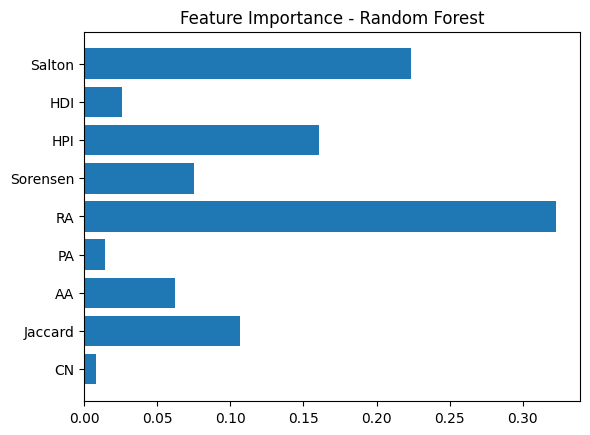

In [13]:
# -------------------------------------------------------------
# Random Forest
# -------------------------------------------------------------
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"\nRandom Forest AUC = {auc_rf:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f"AUC = {auc_rf:.3f}", color="green")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

plt.barh(features, rf_model.feature_importances_)
plt.title("Feature Importance - Random Forest")
plt.show()




c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost AUC = 0.9808


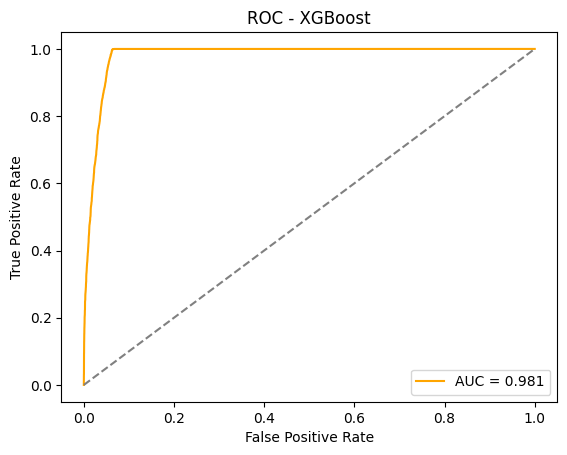

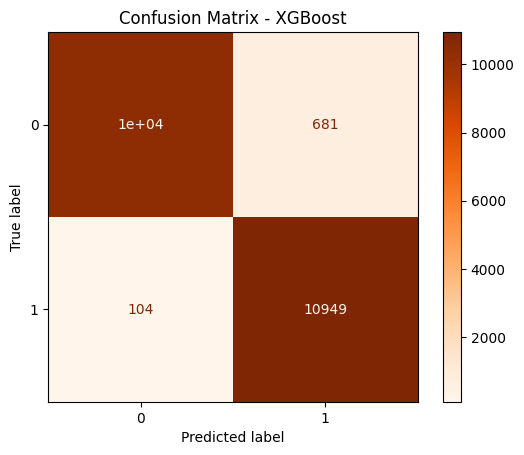

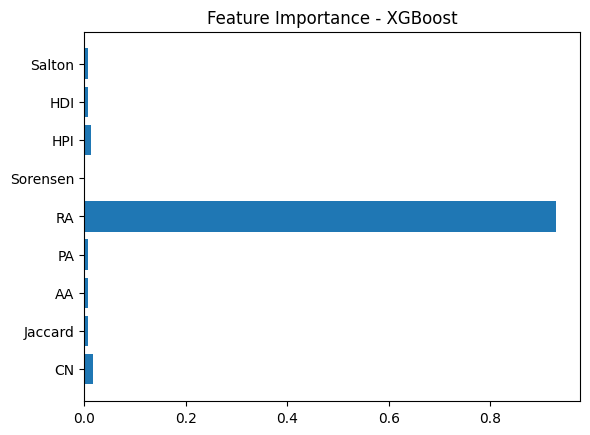

In [14]:
# -------------------------------------------------------------
# XGBoost
# -------------------------------------------------------------
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nXGBoost AUC = {auc_xgb:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr, tpr, label=f"AUC = {auc_xgb:.3f}", color="orange")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot(cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.show()

plt.barh(features, xgb_model.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.show()




Neural Network AUC = 0.9703


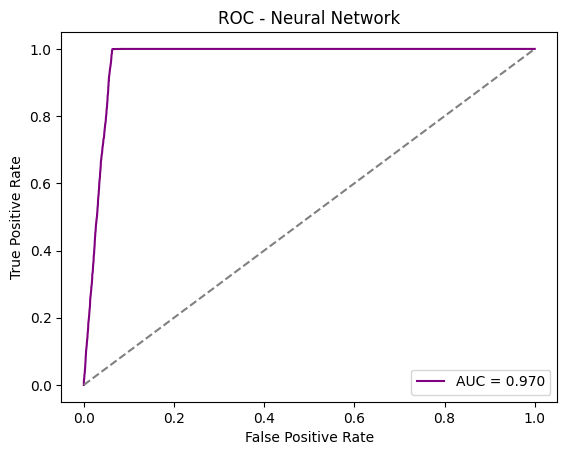

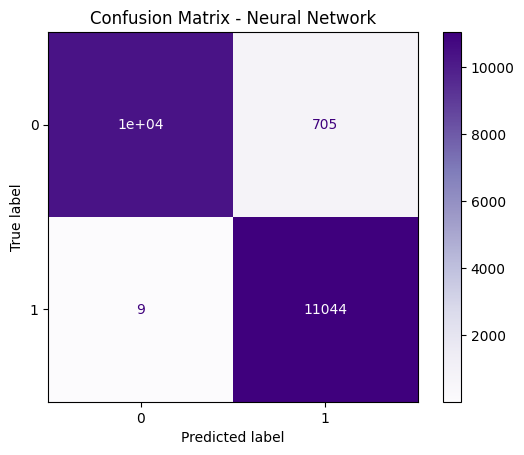

In [15]:
# -------------------------------------------------------------
# Neural Network (MLP)
# -------------------------------------------------------------
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
y_prob_nn = nn_model.predict_proba(X_test)[:, 1]

auc_nn = roc_auc_score(y_test, y_prob_nn)
print(f"\nNeural Network AUC = {auc_nn:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
plt.plot(fpr, tpr, label=f"AUC = {auc_nn:.3f}", color="purple")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC - Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nn)).plot(cmap="Purples")
plt.title("Confusion Matrix - Neural Network")
plt.show()



In [16]:
# -------------------------------------------------------------
# So sánh tổng hợp
# -------------------------------------------------------------
import pandas as pd

results_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "Neural Network"],
    "AUC": [auc_log, auc_rf, auc_xgb, auc_nn]
}).sort_values("AUC", ascending=False)

print("\n===== BẢNG SO SÁNH TỔNG HỢP (AUC) =====")
print(results_summary)


===== BẢNG SO SÁNH TỔNG HỢP (AUC) =====
                 Model       AUC
1        Random Forest  0.992123
2              XGBoost  0.980775
3       Neural Network  0.970284
0  Logistic Regression  0.967656


### Vẽ đường cong Precision–Recall (AUC-PR) để so sánh hiệu suất giữa các mô hình Machine Learning trong bài toán dự đoán liên kết


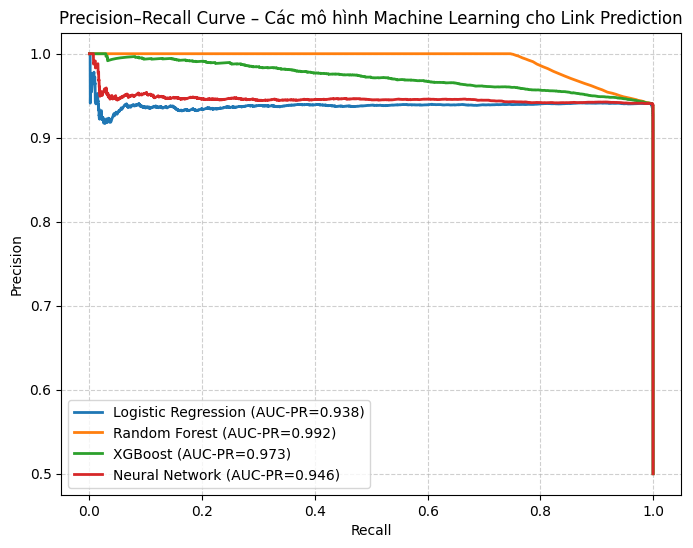

In [17]:
from sklearn.metrics import precision_recall_curve, auc

# === Tính Precision–Recall cho từng mô hình ===
ml_results = []

# Logistic Regression
precision_log, recall_log, _ = precision_recall_curve(y_test, y_prob_log)
auc_pr_log = auc(recall_log, precision_log)
ml_results.append({"method": "Logistic Regression", "precision": precision_log, "recall": recall_log, "auc_pr": auc_pr_log})

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
auc_pr_rf = auc(recall_rf, precision_rf)
ml_results.append({"method": "Random Forest", "precision": precision_rf, "recall": recall_rf, "auc_pr": auc_pr_rf})

# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
auc_pr_xgb = auc(recall_xgb, precision_xgb)
ml_results.append({"method": "XGBoost", "precision": precision_xgb, "recall": recall_xgb, "auc_pr": auc_pr_xgb})

# Neural Network
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_prob_nn)
auc_pr_nn = auc(recall_nn, precision_nn)
ml_results.append({"method": "Neural Network", "precision": precision_nn, "recall": recall_nn, "auc_pr": auc_pr_nn})

# === Vẽ đồ thị Precision–Recall ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for r in ml_results:
    plt.plot(r["recall"], r["precision"], linewidth=2,
             label=f"{r['method']} (AUC-PR={r['auc_pr']:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Các mô hình Machine Learning cho Link Prediction")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### So sánh toàn diện 9 phương pháp (5 thuật toán topo + 4 mô hình Machine Learning) qua biểu đồ ROC Curve và Precision–Recall Curve


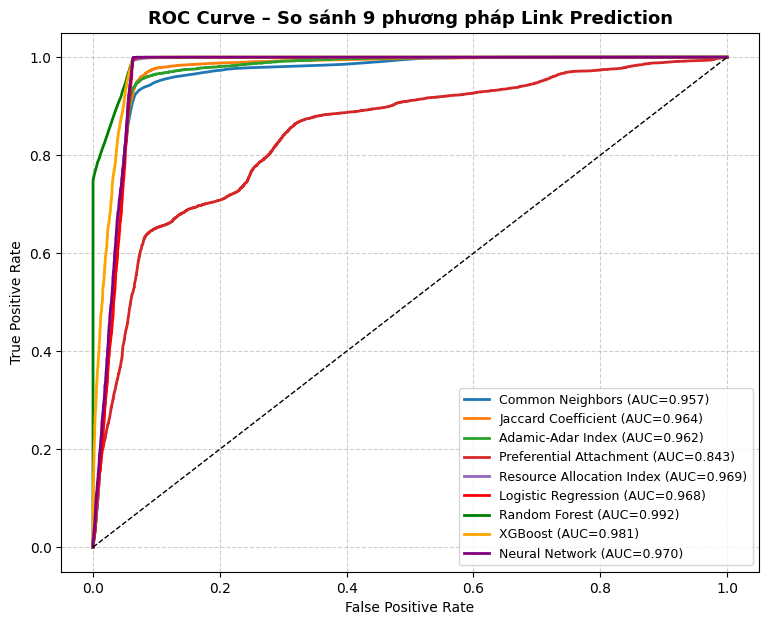

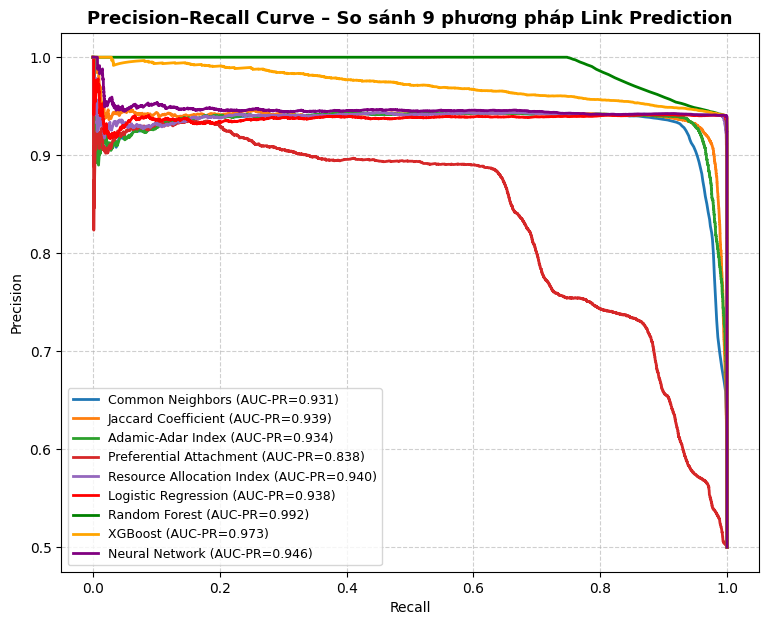

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======================================
# ROC Curve – So sánh 9 phương pháp
# ======================================

plt.figure(figsize=(9, 7))

roc_results_all = []

# --- 5 phương pháp topo ---
methods = ['common_neighbors', 'jaccard', 'adamic_adar', 
           'preferential_attachment', 'resource_allocation']
method_names = ['Common Neighbors', 'Jaccard Coefficient', 
                'Adamic-Adar Index', 'Preferential Attachment', 
                'Resource Allocation Index']

for m, name in zip(methods, method_names):
    y_true = test_data['label']
    y_score = test_data[m]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    roc_results_all.append((name, auc_score))
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc_score:.3f})")

# --- 4 mô hình Machine Learning ---
ml_models = [
    ("Logistic Regression", y_test, y_prob_log, "red"),
    ("Random Forest", y_test, y_prob_rf, "green"),
    ("XGBoost", y_test, y_prob_xgb, "orange"),
    ("Neural Network", y_test, y_prob_nn, "purple")
]

for name, y_true, y_prob, color in ml_models:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    roc_results_all.append((name, auc_score))
    plt.plot(fpr, tpr, linewidth=2, color=color, label=f"{name} (AUC={auc_score:.3f})")

# --- Hoàn thiện biểu đồ ROC ---
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curve – So sánh 9 phương pháp Link Prediction", fontsize=13, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ======================================
# Precision–Recall Curve – So sánh 9 phương pháp
# ======================================

plt.figure(figsize=(9, 7))

pr_results_all = []

# --- 5 phương pháp topo ---
for m, name in zip(methods, method_names):
    y_true = test_data['label']
    y_score = test_data[m]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_pr = auc(recall, precision)
    pr_results_all.append((name, auc_pr))
    plt.plot(recall, precision, linewidth=2, label=f"{name} (AUC-PR={auc_pr:.3f})")

# --- 4 mô hình Machine Learning ---
for name, y_true, y_prob, color in ml_models:
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    auc_pr = auc(recall, precision)
    pr_results_all.append((name, auc_pr))
    plt.plot(recall, precision, linewidth=2, color=color, label=f"{name} (AUC-PR={auc_pr:.3f})")

# --- Hoàn thiện biểu đồ PR ---
plt.title("Precision–Recall Curve – So sánh 9 phương pháp Link Prediction", fontsize=13, fontweight='bold')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()




In [19]:
# ======================================
#  In bảng tổng hợp AUC & AUC-PR
# ======================================
import pandas as pd

df_roc = pd.DataFrame(roc_results_all, columns=["Method", "AUC-ROC"])
df_pr  = pd.DataFrame(pr_results_all, columns=["Method", "AUC-PR"])
df_summary = pd.merge(df_roc, df_pr, on="Method").sort_values("AUC-ROC", ascending=False)

print("\n===== BẢNG TỔNG HỢP KẾT QUẢ =====")
print(df_summary)


===== BẢNG TỔNG HỢP KẾT QUẢ =====
                      Method   AUC-ROC    AUC-PR
6              Random Forest  0.992123  0.991758
7                    XGBoost  0.980775  0.972567
8             Neural Network  0.970284  0.945989
4  Resource Allocation Index  0.968671  0.940047
5        Logistic Regression  0.967656  0.938310
1        Jaccard Coefficient  0.963710  0.938664
2          Adamic-Adar Index  0.962255  0.934169
0           Common Neighbors  0.957391  0.930765
3    Preferential Attachment  0.842844  0.837707


### Phân phối xác suất (Positive vs Negative)

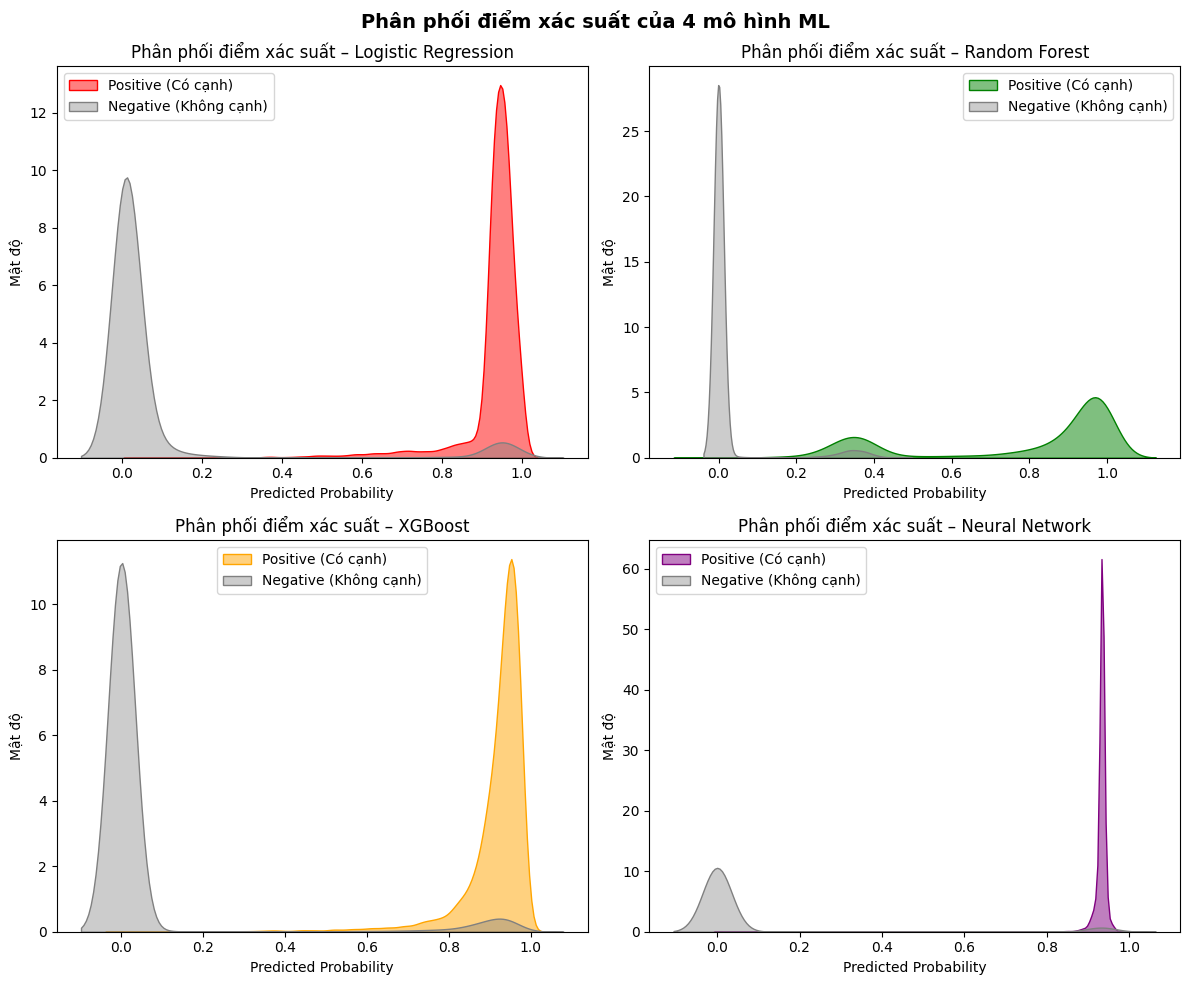

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ==========================================================
# PHÂN PHỐI XÁC SUẤT (Positive vs Negative)
# ==========================================================

plt.figure(figsize=(12, 10))

models_prob = [
    ("Logistic Regression", y_prob_log, "red"),
    ("Random Forest", y_prob_rf, "green"),
    ("XGBoost", y_prob_xgb, "orange"),
    ("Neural Network", y_prob_nn, "purple")
]

for i, (name, y_prob, color) in enumerate(models_prob, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(y_prob[y_test == 1], label="Positive (Có cạnh)", fill=True, color=color, alpha=0.5)
    sns.kdeplot(y_prob[y_test == 0], label="Negative (Không cạnh)", fill=True, color="gray", alpha=0.4)
    plt.title(f"Phân phối điểm xác suất – {name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Mật độ")
    plt.legend()

plt.suptitle("Phân phối điểm xác suất của 4 mô hình ML", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()





### Phân tích FALSE POSITIVE / FALSE NEGATIVE

In [21]:
# ==========================================================
# PHÂN TÍCH FALSE POSITIVE / FALSE NEGATIVE
# ==========================================================

def analyze_errors(model_name, y_true, y_prob, edges_all, topk=5):
    df = pd.DataFrame({
        "edge": edges_all,
        "true_label": y_true,
        "pred_prob": y_prob
    })

    false_pos = df[(df.true_label == 0) & (df.pred_prob > 0.8)].sort_values("pred_prob", ascending=False)
    false_neg = df[(df.true_label == 1) & (df.pred_prob < 0.2)].sort_values("pred_prob")

    print(f"\n=== {model_name} – Phân tích lỗi dự đoán ===")
    print(f"Top {topk} False Positives (dự đoán có cạnh nhưng thực tế không):")
    print(false_pos.head(topk))

    print(f"\nTop {topk} False Negatives (thực tế có cạnh nhưng mô hình bỏ sót):")
    print(false_neg.head(topk))

# Gộp test_edges + test_negative để kiểm tra
test_edges_all = list(test_edges) + list(test_negative)
y_true_all = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_negative))])

# Gọi phân tích cho từng mô hình
analyze_errors("Random Forest", y_true_all, y_prob_rf, test_edges_all)






=== Random Forest – Phân tích lỗi dự đoán ===
Top 5 False Positives (dự đoán có cạnh nhưng thực tế không):
Empty DataFrame
Columns: [edge, true_label, pred_prob]
Index: []

Top 5 False Negatives (thực tế có cạnh nhưng mô hình bỏ sót):
                               edge  true_label  pred_prob
7638      (Liên Bỉnh Phát, Tiểu Vy)         1.0      0.010
6479    (Phi Thanh Vân, Tiết Cương)         1.0      0.015
9504     (Hugh Jackman, Thu Phương)         1.0      0.035
6321        (Ngô Kiến Huy, Ryn Lee)         1.0      0.045
3575  (One Direction, Park Ji Jeon)         1.0      0.050


In [22]:
analyze_errors("XGBoost", y_true_all, y_prob_xgb, test_edges_all)



=== XGBoost – Phân tích lỗi dự đoán ===
Top 5 False Positives (dự đoán có cạnh nhưng thực tế không):
                                         edge  true_label  pred_prob
17374  (Bùi Xuân Trường, Nguyễn Kiều Cẩm Thơ)         0.0   0.981317
14616                 (Bon Jovi, Bích Phương)         0.0   0.980808
11714            (Soobin Hoàng Sơn, Huy Cung)         0.0   0.980741
16363                   (Hương Lan, Duy Mạnh)         0.0   0.973936
20134             (Trang Nhung, Fools Garden)         0.0   0.973348

Top 5 False Negatives (thực tế có cạnh nhưng mô hình bỏ sót):
                             edge  true_label  pred_prob
7638    (Liên Bỉnh Phát, Tiểu Vy)         1.0   0.001210
6479  (Phi Thanh Vân, Tiết Cương)         1.0   0.040621
5672         (Mỹ Duyên, Hữu Châu)         1.0   0.058380
2571      (Vũ Cát Tường, Ryn Lee)         1.0   0.070474
6321      (Ngô Kiến Huy, Ryn Lee)         1.0   0.070474


In [23]:
analyze_errors("Logistic Regression", y_true_all, y_prob_log, test_edges_all)



=== Logistic Regression – Phân tích lỗi dự đoán ===
Top 5 False Positives (dự đoán có cạnh nhưng thực tế không):
                            edge  true_label  pred_prob
12882  (Tuấn Trần, Võ Hoàng Yến)         0.0   0.999947
20856     (Vân Dung, Đỗ Duy Nam)         0.0   0.999761
17208     (Hòa Minzy, Thúy Ngân)         0.0   0.999368
20444   (Cát Phượng, Trấn Thành)         0.0   0.999268
16309      (Khởi My, Trấn Thành)         0.0   0.999236

Top 5 False Negatives (thực tế có cạnh nhưng mô hình bỏ sót):
                                       edge  true_label  pred_prob
3753                   (Song Luân, Uyển Ân)         1.0   0.043737
4983                  (Kim Huyền, Thái Hòa)         1.0   0.064074
671    (Phan Mạnh Quỳnh, Nguyễn Việt Hoàng)         1.0   0.076679
10020                 (Tiên Tiên, Han Sara)         1.0   0.083507
6616                (Hoàng Anh, Ricky Star)         1.0   0.093422


In [24]:
analyze_errors("Neural Network", y_true_all, y_prob_nn, test_edges_all)


=== Neural Network – Phân tích lỗi dự đoán ===
Top 5 False Positives (dự đoán có cạnh nhưng thực tế không):
                                               edge  true_label  pred_prob
14931                           (Đức Huy, Quốc Bảo)         0.0   0.958646
15413                          (Đông Nhi, Khả Ngân)         0.0   0.956640
11068                      (Thanh Hằng, Minh Trang)         0.0   0.953845
12018                        (Giang Còi, Trung Dân)         0.0   0.953648
21318  (Nguyễn Thúc Thùy Tiên, Ninh Dương Lan Ngọc)         0.0   0.952966

Top 5 False Negatives (thực tế có cạnh nhưng mô hình bỏ sót):
                             edge  true_label  pred_prob
3753         (Song Luân, Uyển Ân)         1.0   0.004607
6479  (Phi Thanh Vân, Tiết Cương)         1.0   0.004832
5403     (Anh Tú Atus, Lou Hoàng)         1.0   0.105169
7638    (Liên Bỉnh Phát, Tiểu Vy)         1.0   0.114769


### So sánh mức độ quan trọng của các đặc trưng (Feature Importance) giữa hai mô hình Random Forest và XGBoost


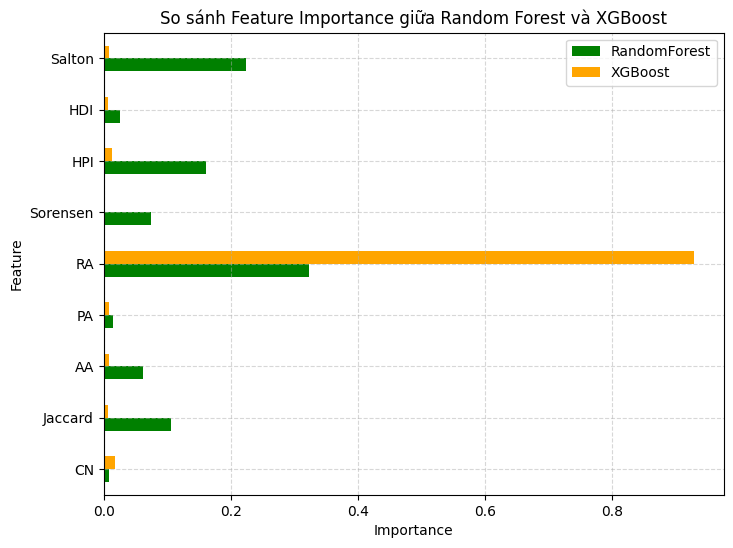

In [25]:
# ==========================================================
#  FEATURE IMPORTANCE (RF & XGB)
# ==========================================================

features = ["CN","Jaccard","AA","PA","RA","Sorensen","HPI","HDI","Salton"]

importance_df = pd.DataFrame({
    "Feature": features,
    "RandomForest": rf_model.feature_importances_,
    "XGBoost": xgb_model.feature_importances_
}).set_index("Feature")

importance_df.plot(kind="barh", figsize=(8,6), color=["green","orange"])
plt.title("So sánh Feature Importance giữa Random Forest và XGBoost")
plt.xlabel("Importance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()




### Bảng tổng hợp các chỉ số đánh giá (Accuracy, Recall, F1-Score, AUC) và biểu đồ so sánh AUC giữa các mô hình Machine Learning



===== BẢNG TỔNG HỢP CHỈ SỐ CỦA CÁC MÔ HÌNH ML =====
                 Model  Accuracy    Recall  F1-Score       AUC
0  Logistic Regression  0.964354  0.991043  0.965280  0.967656
1        Random Forest  0.871754  0.743509  0.852888  0.992123
2              XGBoost  0.964489  0.990591  0.965393  0.980775
3       Neural Network  0.967701  0.999186  0.968687  0.970284


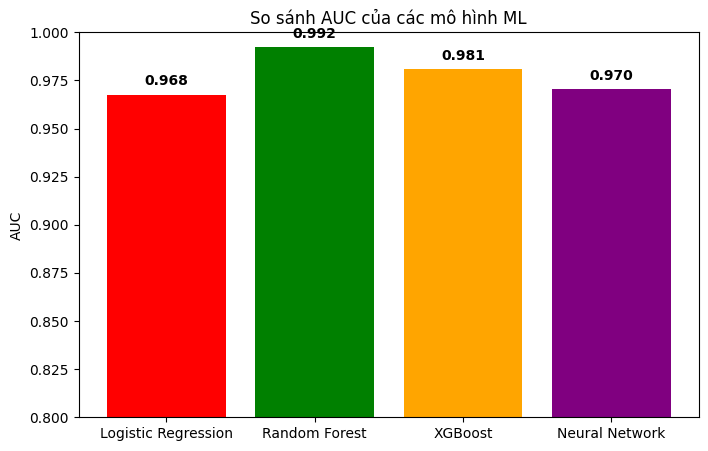

In [ ]:
# ==========================================================
# BẢNG TỔNG HỢP CÁC CHỈ SỐ (ACC, REC, F1, AUC)
# ==========================================================

models_pred = [
    ("Logistic Regression", y_pred_log, y_prob_log),
    ("Random Forest", y_pred_rf, y_prob_rf),
    ("XGBoost", y_pred_xgb, y_prob_xgb),
    ("Neural Network", y_pred_nn, y_prob_nn)
]

metrics = []
for name, y_pred, y_prob in models_pred:
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })
pd.set_option("display.precision", 6)
df_metrics = pd.DataFrame(metrics)
print("\n===== BẢNG TỔNG HỢP CHỈ SỐ CỦA CÁC MÔ HÌNH ML =====")
print(df_metrics)

# (Tùy chọn) Vẽ biểu đồ cột
plt.figure(figsize=(8,5))
plt.bar(df_metrics["Model"], df_metrics["AUC"], color=["red","green","orange","purple"])
plt.title("So sánh AUC của các mô hình ML")
plt.ylabel("AUC")
plt.ylim(0.8, 1.0)
for i, v in enumerate(df_metrics["AUC"]):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()

### Dự đoán top các cặp nghệ sĩ có khả năng hợp tác trong tương lai trực quan hóa top-k cặp nghệ sĩ được dự đoán

In [ ]:
def predict_future_collaborations(G_train, model, model_name, topk=10):
    """
    Dự đoán top các cặp nghệ sĩ có khả năng hợp tác trong tương lai 
    """
    print(f"\n=== {model_name} – Dự đoán {topk} cặp nghệ sĩ có khả năng hợp tác trong tương lai ===")

    nodes = list(G_train.nodes())
    candidate_edges = []
    features = []

    # Sinh các cặp chưa có cạnh
    for _ in range(5000):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_train.has_edge(u, v):
            candidate_edges.append((u, v))
            features.append(compute_features(G_train, u, v))

    X_candidates = np.array(features)

    # Dự đoán xác suất bằng pipeline (scaler sẽ tự áp dụng)
    probs = model.predict_proba(X_candidates)[:, 1]

    # Lấy top-k
    topk_edges = [edge for _, edge in sorted(zip(probs, candidate_edges), reverse=True)[:topk]]

    # In kết quả
    for rank, (u, v) in enumerate(topk_edges, 1):
        print(f"{rank:2d}. ({u}, {v})")

    return topk_edges


In [28]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_predicted_pairs(G_train, predicted_edges, title_suffix="Top dự đoán", max_cases=3):
    """
    Trực quan hóa top-k cặp nghệ sĩ được dự đoán hợp tác trong tương lai.
    - predicted_edges: danh sách [(u, v)] từ predict_future_collaborations()
    - G_train: đồ thị huấn luyện
    - Node phụ: xám, mờ
    - Node chính: đỏ–xanh, nổi bật, vẽ sau cùng để đè lên cạnh
    """
    n_cases = min(len(predicted_edges), max_cases)
    fig, axes = plt.subplots(1, n_cases, figsize=(6 * n_cases, 5))
    if n_cases == 1:
        axes = [axes]

    for i, (u, v) in enumerate(predicted_edges[:n_cases]):
        ax = axes[i]

        # Tập hàng xóm của 2 node chính
        neighbors_u = set(G_train.neighbors(u)) if u in G_train else set()
        neighbors_v = set(G_train.neighbors(v)) if v in G_train else set()
        sub_nodes = {u, v} | neighbors_u | neighbors_v
        subG = G_train.subgraph(sub_nodes)
        pos = nx.spring_layout(subG, seed=42)

        # --- 1. Node phụ (xám, mờ)
        other_nodes = list(sub_nodes - {u, v})
        nx.draw_networkx_nodes(
            subG, pos, nodelist=other_nodes,
            node_color="lightgray", node_size=350, alpha=0.4, ax=ax
        )

        # --- 2. Cạnh phụ (xám nhạt)
        nx.draw_networkx_edges(
            subG, pos, edge_color="gray", width=1, alpha=0.3, ax=ax
        )

        # --- 3. Cạnh chính (vẽ nổi bật hơn)
        if not G_train.has_edge(u, v):
            ax.plot(
                [pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
                'r--', linewidth=3, alpha=0.9, label="Cạnh dự đoán"
            )
        else:
            ax.plot(
                [pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
                'g-', linewidth=3, alpha=0.9, label="Cạnh thật"
            )

        # --- 4. Node chính (đỏ–xanh, rõ nét, vẽ sau cùng để đè lên các cạnh)
        nx.draw_networkx_nodes(
            subG, pos, nodelist=[u], node_color="red",
            node_size=650, edgecolors="black", linewidths=1.8, ax=ax
        )
        nx.draw_networkx_nodes(
            subG, pos, nodelist=[v], node_color="royalblue",
            node_size=650, edgecolors="black", linewidths=1.8, ax=ax
        )

        # --- 5. Label: node phụ mờ, node chính rõ
        for node in other_nodes:
            nx.draw_networkx_labels(
                subG, pos, labels={node: node},
                font_size=8, font_color="dimgray", alpha=0.5, ax=ax
            )
        nx.draw_networkx_labels(
            subG, pos, labels={u: u},
            font_size=10, font_weight="bold", font_color="darkred", ax=ax
        )
        nx.draw_networkx_labels(
            subG, pos, labels={v: v},
            font_size=10, font_weight="bold", font_color="navy", ax=ax
        )

        # --- 6. Cài đặt đồ họa
        ax.set_title(f"Cặp ({u}, {v}) – {title_suffix}", fontsize=12, fontweight="bold")
        ax.axis("off")

    plt.tight_layout()
    plt.show()



=== Logistic Regression – Dự đoán 10 cặp nghệ sĩ có khả năng hợp tác trong tương lai ===
 1. (Ốc Thanh Vân, Thu Hiền)
 2. (Ốc Thanh Vân, Hugh Jackman)
 3. (Ưng Hoàng Phúc, Nguyễn Đức Thịnh)
 4. (Ưng Hoàng Phúc, Hiệp Gà)
 5. (Đức Phúc, Võ Thành Trung)
 6. (Đức Phúc, Tự Long)
 7. (Đức Phúc, Pháo Northside)
 8. (Đức Phúc, Nguyễn Minh Triết)
 9. (Đức Phúc, Lynk Lee)
10. (Đức Khuê, Trần Phan Huy Khánh)


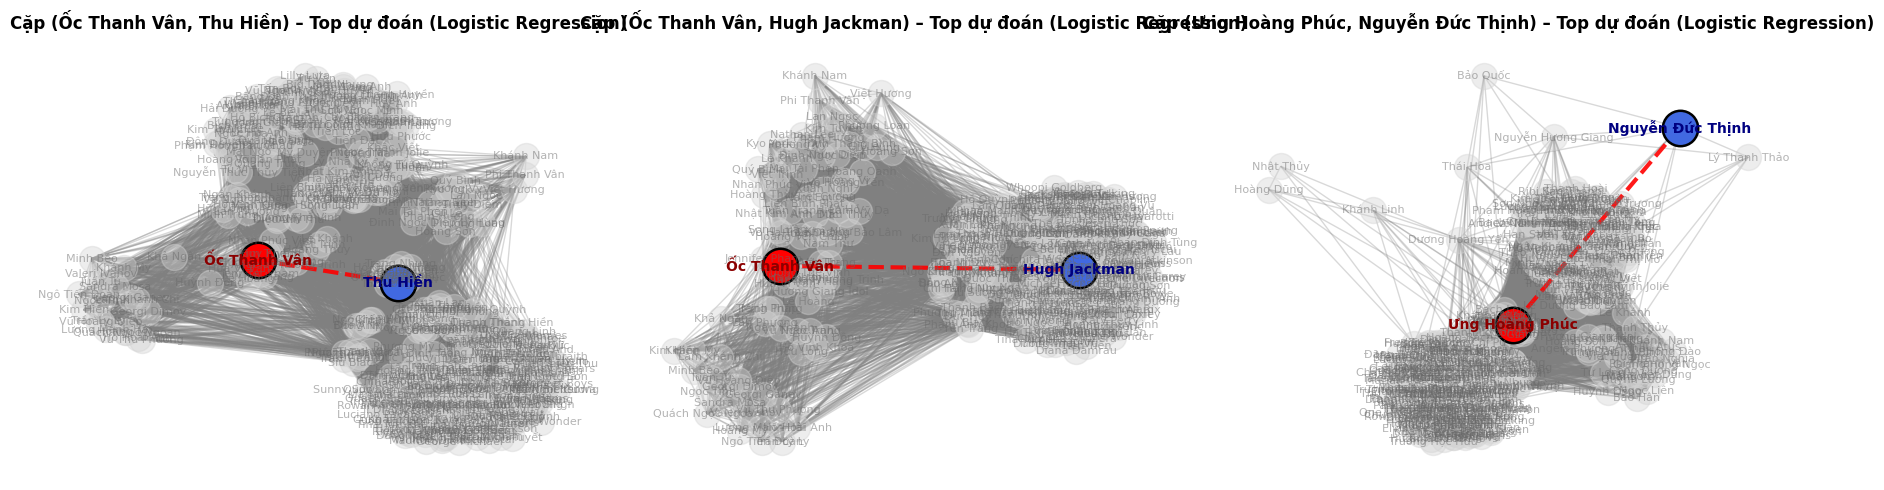

In [29]:
top_log = predict_future_collaborations(G_train, log_model, "Logistic Regression", topk=10)

visualize_predicted_pairs(G_train, top_log, "Top dự đoán (Logistic Regression)", max_cases=3)



=== Random Forest – Dự đoán 10 cặp nghệ sĩ có khả năng hợp tác trong tương lai ===
 1. (Hiền Hồ, Ngô Thanh Vân)
 2. (Minh Quân, Minh Nhí)
 3. (Hương Ly, Miu Lê)
 4. (Ngọc Trai, Hari Won)
 5. (Sỹ Luân, Minh Khang)
 6. (Mâu Thủy, Ngô Thanh Vân)
 7. (Võ Tấn Phát, Xuân Lan)
 8. (Vân Trang, Nguyễn Thúc Thùy Tiên)
 9. (Trấn Thành, Vũ Ngọc Anh)
10. (Kim Huyền, Ninh Dương Lan Ngọc)


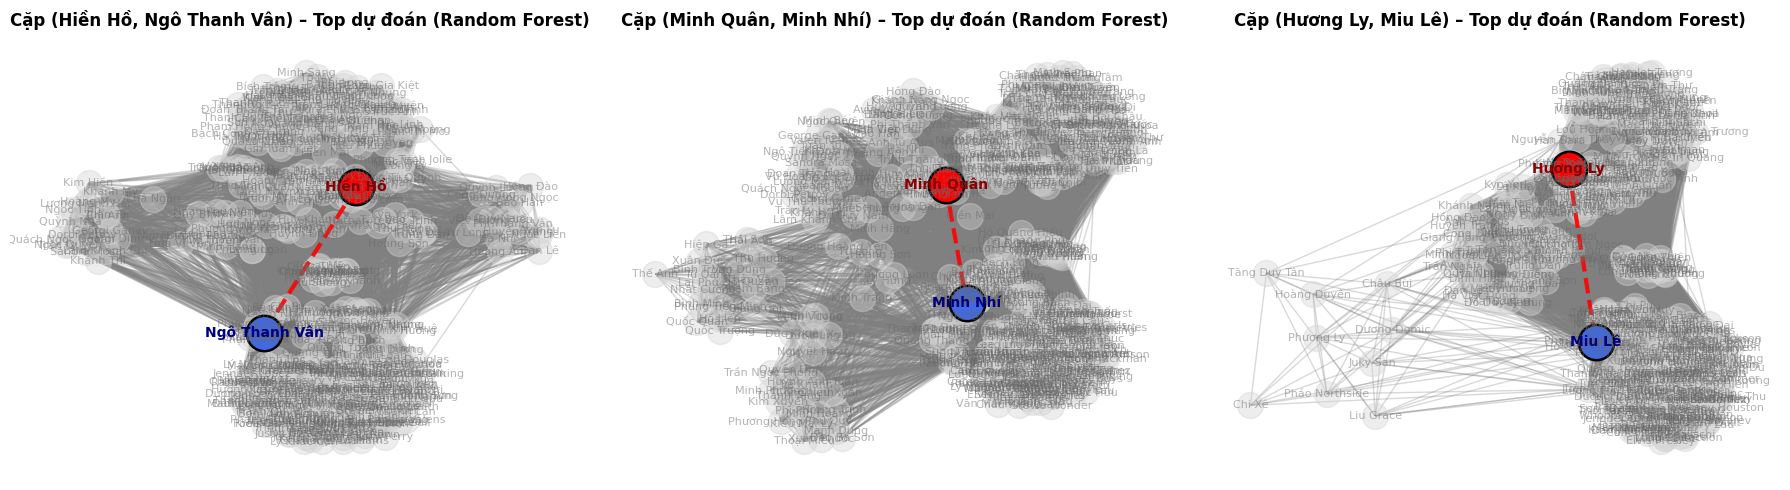

In [30]:
top_rf  = predict_future_collaborations(G_train, rf_model,  "Random Forest", topk=10)

visualize_predicted_pairs(G_train, top_rf,  "Top dự đoán (Random Forest)", max_cases=3)





=== XGBoost – Dự đoán 10 cặp nghệ sĩ có khả năng hợp tác trong tương lai ===
 1. (Lam Anh, Hữu Phước)
 2. (Bảo Yến, Ricky Star)
 3. (Siu Black, Tiên Tiên)
 4. (Duy Mạnh, Thanh Lan)
 5. (Hương Ly, Sơn Ngọc Minh)
 6. (Mai Thu Huyền, Lou Hoàng)
 7. (Luciano Pavarotti, Đức Huy)
 8. (Bryan Adams, Trịnh Công Sơn)
 9. (Duy Mạnh, Phương Dung)
10. (Christina Aguilera, Backstreet Boys)


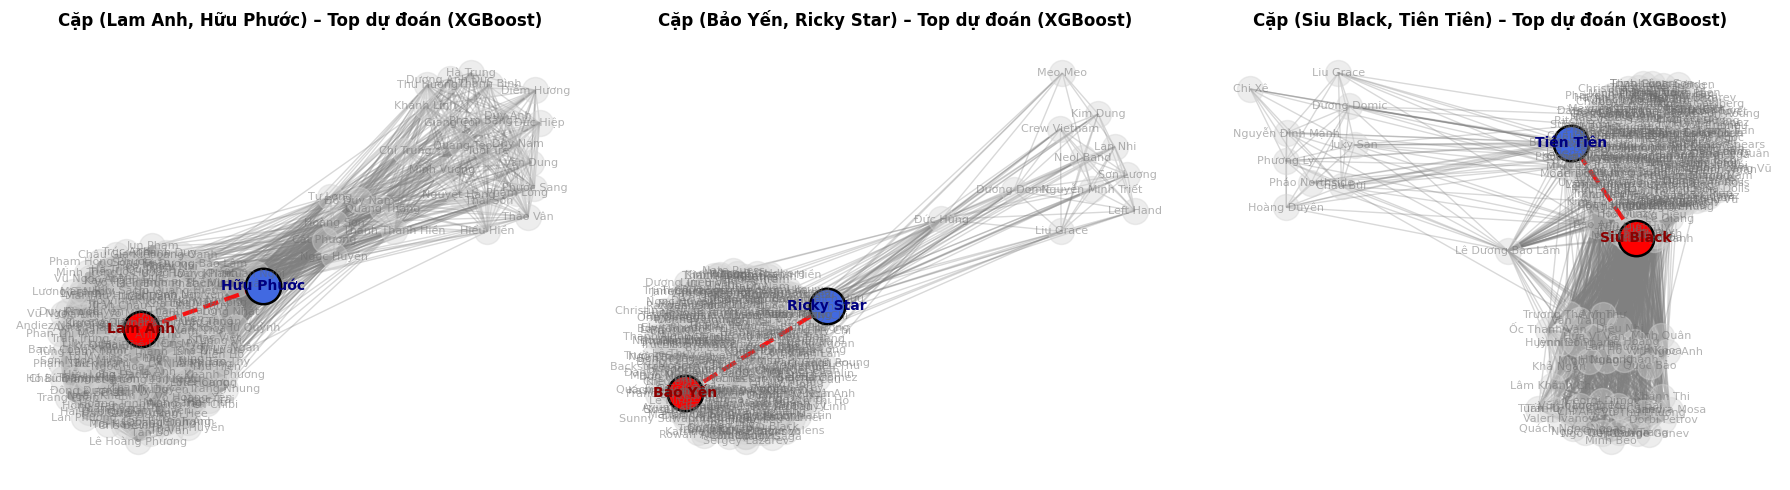

In [31]:
top_xgb = predict_future_collaborations(G_train, xgb_model, "XGBoost", topk=10)

visualize_predicted_pairs(G_train, top_xgb, "Top dự đoán (XGBoost)", max_cases=3)




=== Neural Network – Dự đoán 10 cặp nghệ sĩ có khả năng hợp tác trong tương lai ===
 1. (Ryn Lee, Bùi Anh Tuấn)
 2. (Ryn Lee, Phương Anh Đào)
 3. (Ryn Lee, Isaac Mie)
 4. (Trần Lực, Phạm Lưu Tuấn Tài)
 5. (Lê Nguyễn Trung Đan, Trung Quân)
 6. (Khoi Vu, Huỳnh Trấn Thành)
 7. (Lê Trường Sơn, Khoi Vu)
 8. (Bùi Thị Bích Phương, Phan Văn Đức)
 9. (Bùi Thị Bích Phương, Lê Thành Dương)
10. (Hồng Phúc, Mạnh Trường)


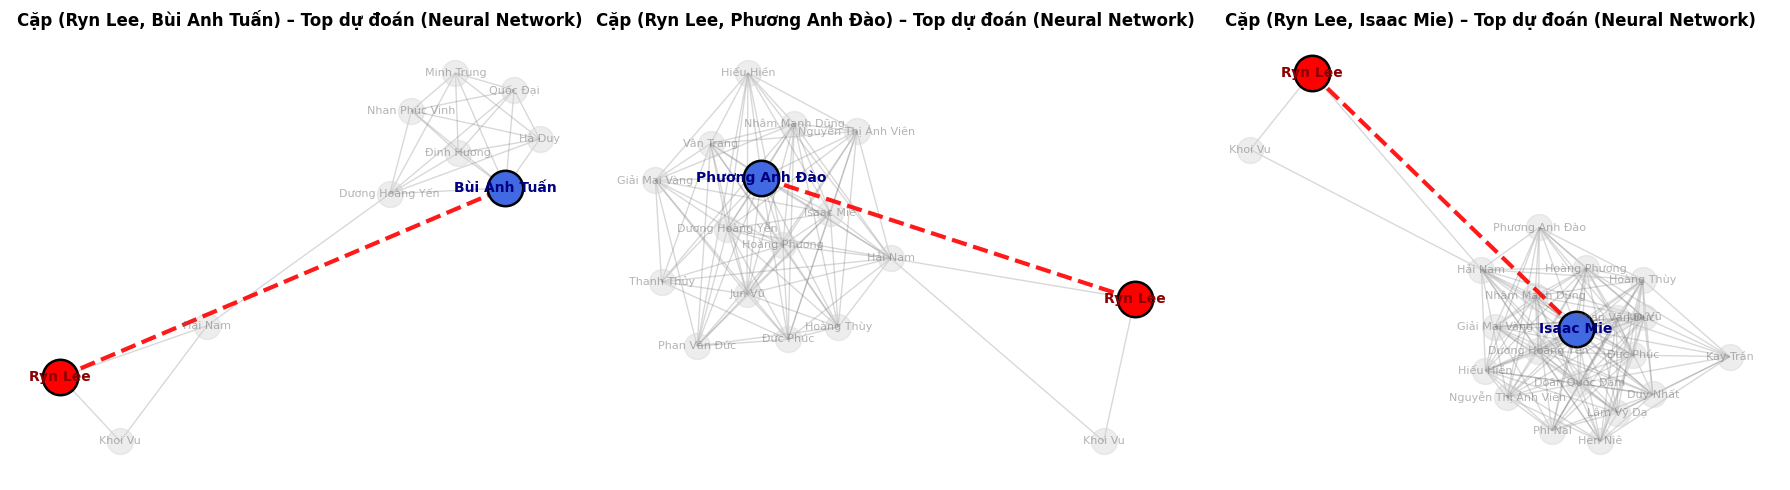

In [32]:
top_nn  = predict_future_collaborations(G_train, nn_model,  "Neural Network", topk=10)
visualize_predicted_pairs(G_train, top_nn,  "Top dự đoán (Neural Network)", max_cases=3)